In [1]:
from astropy import constants as const
print(const.R_sun.value)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
Rsol = const.R_sun.value
Lsol = const.L_sun.value
Lzp = 3.0128e28
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 

695700000.0


Read in the target data

In [2]:
df = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18.csv')

Read in the Vband magnitudes

In [3]:
sbd = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/simbad.txt',sep='|',skiprows=5)[1:]
sbd.drop(columns=[' #  ','         identifier         ','Mag B ','Mag R ','Mag I ','#not'],inplace=True)
sbd.rename(columns={'typed ident ': 'KICID', 'Mag V ':'Vmag'},inplace=True)

In [4]:
sbd.dropna(inplace=True)
sbd['KICID'] = sbd['KICID'].apply(lambda x: x[4:]).str.strip().astype(int)
sbd['Vmag'] = sbd['Vmag'].str.strip()
sbd = sbd[~(sbd.Vmag.values == '~')].reset_index(drop=True)
sbd['Vmag'] = sbd.Vmag.astype(float)

Calculate the de-reddened V-Ks

In [5]:
df = pd.merge(df, sbd, on='KICID', how='left')

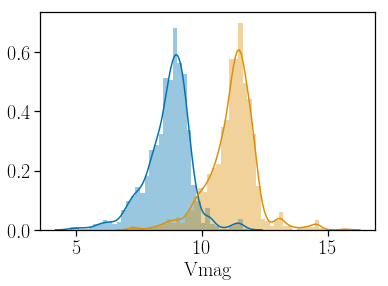

In [6]:
sel = ~np.isnan(df.Vmag.values)
Kmag = df.Kmag[sel]
Vmag = df.Vmag[sel]
sns.distplot(Kmag)
sns.distplot(Vmag)

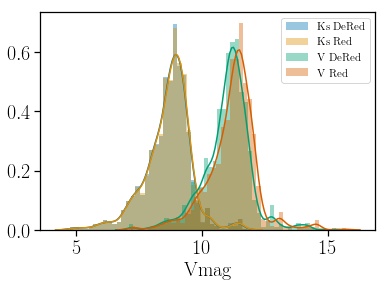

In [7]:
Aks = df.Aks.values[sel]
Av = 3.1 * df.Ebv.values[sel]
mK = Kmag - Aks
mV = Vmag - Av
VKs = mV - mK
sns.distplot(mK, label='Ks DeRed')
sns.distplot(Kmag, label='Ks Red')
sns.distplot(mV, label='V DeRed')
sns.distplot(Vmag, label='V Red')
plt.legend()

Calculate the Flower bolometric corrections

In [8]:
def get_flower(teff):
    lteff = np.log10(teff)
    BCv = np.full(len(lteff), np.nan)

    BCv[lteff<3.70] = (-0.190537291496456*10.0**5) + \
    (0.155144866764412*10.0**5*lteff[lteff<3.70]) + \
    (-0.421278819301717*10.0**4.0*lteff[lteff<3.70]**2.0) + \
    (0.381476328422343*10.0**3*lteff[lteff<3.70]**3.0)

    BCv[(3.70<lteff) & (lteff<3.90)] = (-0.370510203809015*10.0**5) + \
    (0.385672629965804*10.0**5*lteff[(3.70<lteff) & (lteff<3.90)]) + \
    (-0.150651486316025*10.0**5*lteff[(3.70<lteff) & (lteff<3.90)]**2.0) + \
    (0.261724637119416*10.0**4*lteff[(3.70<lteff) & (lteff<3.90)]**3.0) + \
    (-0.170623810323864*10.0**3*lteff[(3.70<lteff) & (lteff<3.90)]**4.0) \

    BCv[lteff>3.90] = (-0.118115450538963*10.0**6) + \
    (0.137145973583929*10.0**6*lteff[lteff > 3.90]) + \
    (-0.636233812100225*10.0**5*lteff[lteff > 3.90]**2.0) + \
    (0.147412923562646*10.0**5*lteff[lteff > 3.90]**3.0) + \
    (-0.170587278406872*10.0**4*lteff[lteff > 3.90]**4.0) + \
    (0.788731721804990*10.0**2*lteff[lteff > 3.90]**5.0)

    return BCv

In [9]:
BCv = get_flower(df.Teff[sel])
BCk = VKs + BCv
casagrande = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/BCs/casagrande_bcs_0.0_singular.csv')
df = pd.merge(df, casagrande, on='KICID', how='left')
BCk_casagrande = df.BC_K.values[sel]

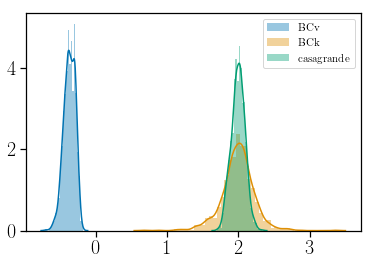

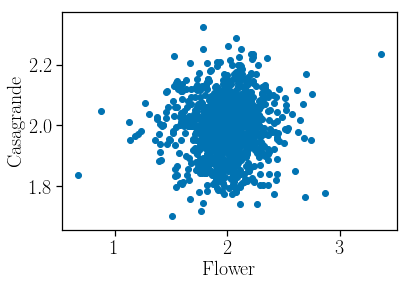

In [10]:
sns.distplot(BCv, label='BCv')
sns.distplot(BCk, label='BCk')
sns.distplot(BCk_casagrande, label='casagrande')
plt.legend()
plt.show()
plt.scatter(BCk, BCk_casagrande)
plt.xlabel('Flower')
plt.ylabel('Casagrande')
plt.show()

# There seems to be zero correlation between the Flower values and the Casagrande values?

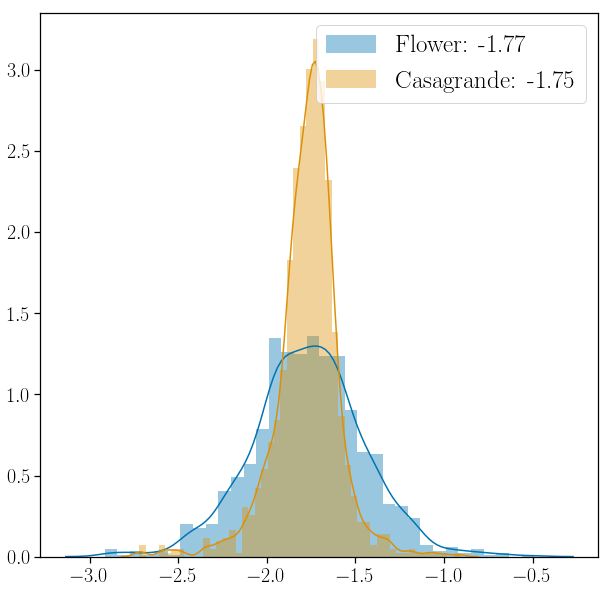

In [16]:
Mk = df.Mbol.values[sel] - BCk
Mk_casagrande = df.Mbol.values[sel] - BCk_casagrande
fig = plt.figure(figsize=(10,10))
sns.distplot(Mk, label='Flower: '+str(np.round(np.median(Mk),2)))
sns.distplot(Mk_casagrande, label='Casagrande: '+str(np.round(np.median(Mk_casagrande),2)))
plt.legend(fontsize=25)
